# Impact of clustering on classification results, and stats

The purpose of this notebook is to observe how the data responds to being clustered by cd-hit at different threshold.

In a second step, we perform deterministic randomized undersampling, to determine the smallest number of samples that leads to good classification results.

Then, we undersample the majority class, to test whether that makes its score approach that of the minority class.

Finally, we recreated some of the plots from Notebook 2, after a 70% cluster threshold has been applied.

## Imports

In [1]:
from subpred.transporter_dataset import create_dataset, get_clustering_stats
from subpred.compositions import calculate_aac, calculate_paac
from subpred.plots import (
    labeled_clustermap,
    get_clusters,
    corr_heatmap,
    pca_plot_2d,
    pca_plot_3d,
    perform_pca,
    feature_importance_plot,
    downsample_majority_class_plot,
    downsampling_plot
)
from subpred.cdhit import cd_hit
import seaborn as sns

In [2]:
df = create_dataset(
    keywords_substrate_filter = ["Amino-acid transport","Sugar transport"],
    keywords_component_filter = ["Transmembrane"],
    keywords_transport_filter = ["Transport"],
    input_file = "../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate = "keep",
    outliers=["O81775", "Q9SW07", "Q9FHH5", "Q8S8A0", "Q3E965", "Q3EAV6", "Q3E8L0"],
    verbose = True,
    tax_ids_filter = [3702],
    output_log = "../logs/athaliana_amino_sugar_dataset.log",
    # sequence_clustering = 70
)
df.columns

Index(['keywords_transport', 'keywords_location', 'keywords_transport_related',
       'gene_names', 'protein_names', 'tcdb_id', 'tcdb_class', 'organism_id',
       'sequence'],
      dtype='object')

In [3]:
df_stats_long = get_clustering_stats(df)
df_stats_long

,identity_threshold,kw_type,keyword,count
0,40,keywords_location,Cell membrane,13
1,40,keywords_location,Endoplasmic reticulum,4
2,40,keywords_location,Membrane,52
3,40,keywords_location,Mitochondrion,1
4,40,keywords_location,Plastid inner membrane,1
...,...,...,...,...
89,100,keywords_transport_related,Antiport,19
90,100,keywords_transport_related,Symport,39
91,100,keywords_transport_related,Transport,165
92,100,tcdb_class,0.0,108


In [4]:
def pivot(df_stats_long, kw_type):
    return df_stats_long[df_stats_long.kw_type == kw_type].pivot(
        index="identity_threshold", columns="keyword", values="count"
    ).fillna(0).convert_dtypes(int)

keyword,Amino-acid transport,Sugar transport
identity_threshold,,
40,16,36
50,23,55
60,27,76
70,33,84
80,41,94
90,46,110
100,47,118


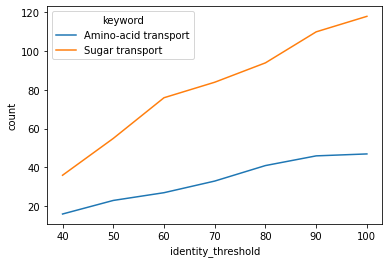

In [5]:
sns.lineplot(
    data=df_stats_long[df_stats_long.kw_type == "keywords_transport"],
    x="identity_threshold",
    y="count",
    hue="keyword",
)
pivot(df_stats_long, "keywords_transport")

keyword,Cell membrane,Endoplasmic reticulum,Membrane,Mitochondrion,Nucleus,Plastid inner membrane,Transmembrane
identity_threshold,,,,,,,
40,13,4,52,1,0,1,52
50,23,5,78,1,0,1,78
60,31,5,103,1,0,1,103
70,34,6,117,1,0,1,117
80,43,7,135,2,1,1,135
90,51,8,156,2,1,1,156
100,53,8,165,2,1,1,165


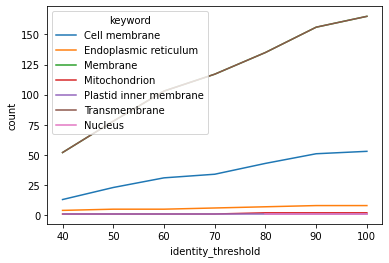

In [6]:
sns.lineplot(
    data=df_stats_long[df_stats_long.kw_type == "keywords_location"],
    x="identity_threshold",
    y="count",
    hue="keyword",
)
pivot(df_stats_long, "keywords_location")

keyword,Antiport,Symport,Transport
identity_threshold,,,
40,7,6,52
50,9,10,78
60,9,19,103
70,11,22,117
80,12,30,135
90,17,38,156
100,19,39,165


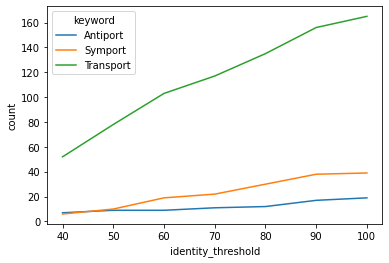

In [7]:
sns.lineplot(
    data=df_stats_long[df_stats_long.kw_type == "keywords_transport_related"],
    x="identity_threshold",
    y="count",
    hue="keyword",
)
pivot(df_stats_long, "keywords_transport_related")

keyword,0.0,2.A
identity_threshold,,
40,31,21
50,48,30
60,64,39
70,75,42
80,88,47
90,100,56
100,108,57


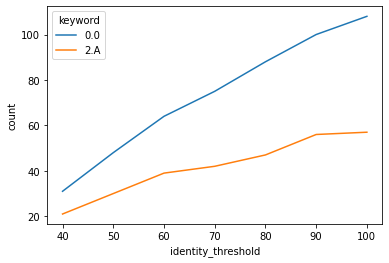

In [8]:
sns.lineplot(
    data=df_stats_long[df_stats_long.kw_type == "tcdb_class"],
    x="identity_threshold",
    y="count",
    hue="keyword",
)
pivot(df_stats_long, "tcdb_class")

<AxesSubplot:xlabel='Total Samples', ylabel='Score'>

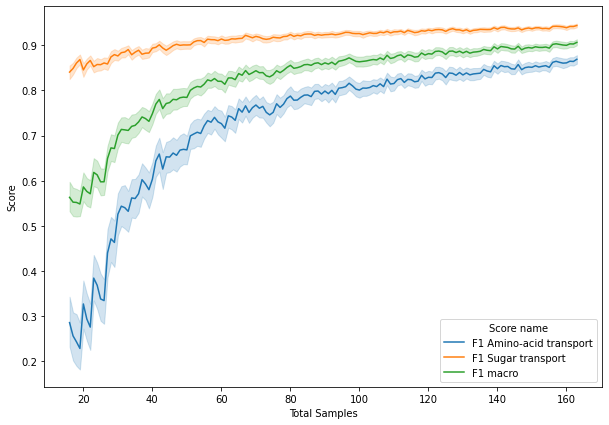

In [9]:
df_aac = calculate_aac(df.sequence)
labels = df.keywords_transport.rename("labels")

downsampling_plot(df_aac, labels)

<AxesSubplot:xlabel='|Amino-acid transport|/|Sugar transport|', ylabel='Score'>

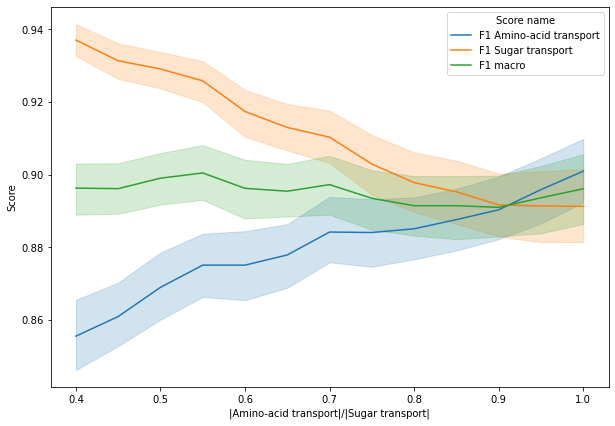

In [10]:
df_aac = calculate_aac(df.sequence)
labels = df.keywords_transport.rename("labels")
downsample_majority_class_plot(df_aac, labels, n_jobs=-1)

## Plots at 70% cluster threshold

In [11]:
df_clustered = create_dataset(
    keywords_substrate_filter = ["Amino-acid transport","Sugar transport"],
    keywords_component_filter = ["Transmembrane"],
    keywords_transport_filter = ["Transport"],
    input_file = "../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate = "keep",
    outliers=["O81775", "Q9SW07", "Q9FHH5", "Q8S8A0", "Q3E965", "Q3EAV6", "Q3E8L0"],
    verbose = True,
    tax_ids_filter = [3702],
    output_log = "../logs/athaliana_amino_sugar_dataset.log",
    sequence_clustering = 70
)

cd-hit: clustered 165 sequences into 117 clusters at threshold 70


In [12]:
df_aac_clustered = calculate_aac(df_clustered.sequence)
df_paac_clustered = calculate_paac(df_clustered.sequence)
labels_clustered = df_clustered.keywords_transport.rename("labels")

### Feature importance

Compared to the unclustered plot from notebook 2, H has lost a significant amount of importance, while K is now more important. This could be related to the lower percentage of sugar transporters in the clustered dataset.

<AxesSubplot:xlabel='Feature', ylabel='Normalized score'>

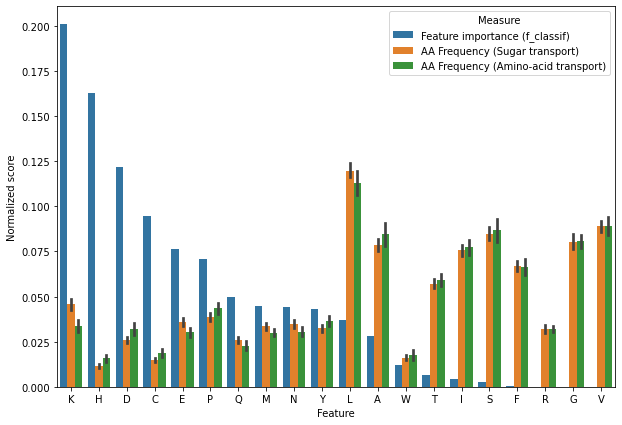

In [13]:
feature_importance_plot(df_aac_clustered, labels_clustered, method="f_classif")

### PCA



Again, there is a circular cluster of aa transporters in the middle, surrounded by sugar transporters. Two or three dimensions are still not enough for training a good model, but it might work in higher dimensions.

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

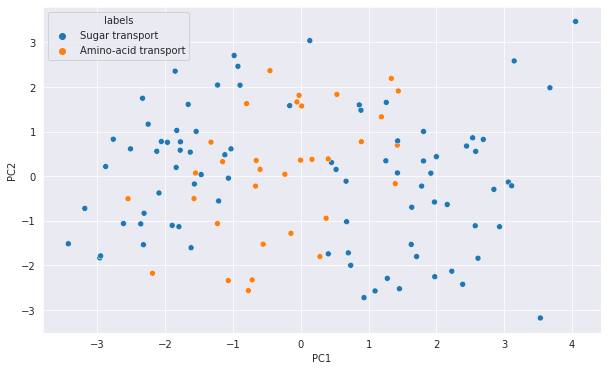

In [14]:
pca_plot_2d(df_aac_clustered, labels_clustered)

The PAAC plot shows a similar pattern, with a distant cluster of sugar transporters in the top right.

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

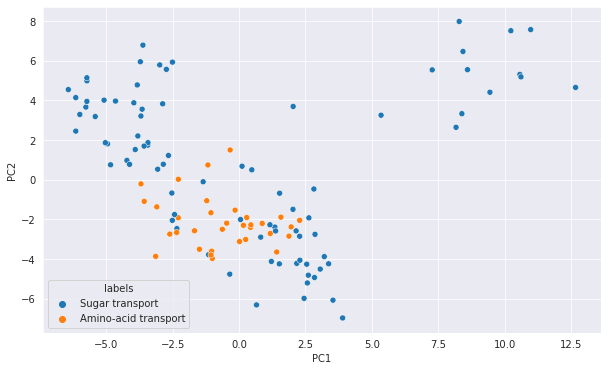

In [15]:
pca_plot_2d(df_paac_clustered, labels_clustered)

Upon further investigation, we find the SWEET family again. We already decided in notebook 1 to include them in the dataset, and they do not disturb the pattern of sugar transporters having higher variance than aa transporters. 

In [16]:
df_pca = perform_pca(df_paac_clustered, labels_clustered, 2)
df.loc[df_pca[df_pca.PC1 > 5].index].gene_names.str.split().transform(lambda x: x[0])

Uniprot
Q84WN3    SWEET17
Q9FGQ2    SWEET13
Q6NQN5     SWEET3
Q9FY94    SWEET15
Q9C9M9     SWEET6
Q8LFH5     SWEET8
Q9SMM5    SWEET11
Q8L9J7     SWEET1
Q944M5     SWEET4
Q9ZV02     SWEET9
Q9LH79     SWEET2
Q9LUE3    SWEET10
Q9FM10     SWEET5
Name: gene_names, dtype: object

The 3D plot looks similar, more dimensions might be necessary

<Axes3DSubplot:xlabel='PC1', ylabel='PC2'>

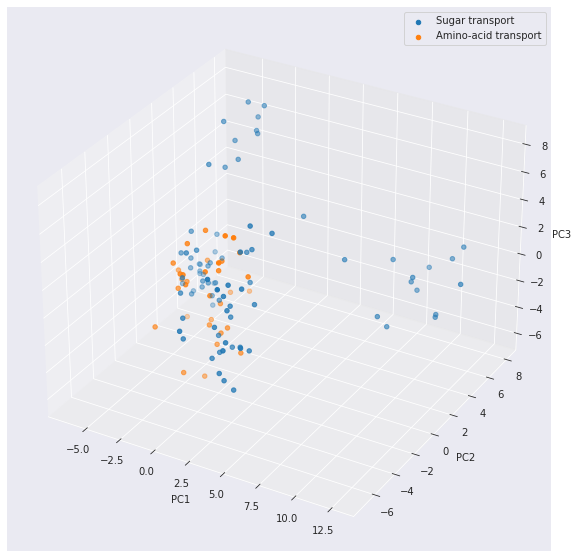

In [17]:
pca_plot_3d(df_paac_clustered, labels_clustered)

In [18]:
df_clustered.columns

Index(['keywords_transport', 'keywords_location', 'keywords_transport_related',
       'gene_names', 'protein_names', 'tcdb_id', 'tcdb_class', 'organism_id',
       'sequence'],
      dtype='object')

## Clustering heatmaps

Classes are still not separable very well through hierarchical clustering. 

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7fba2d3ed460>)

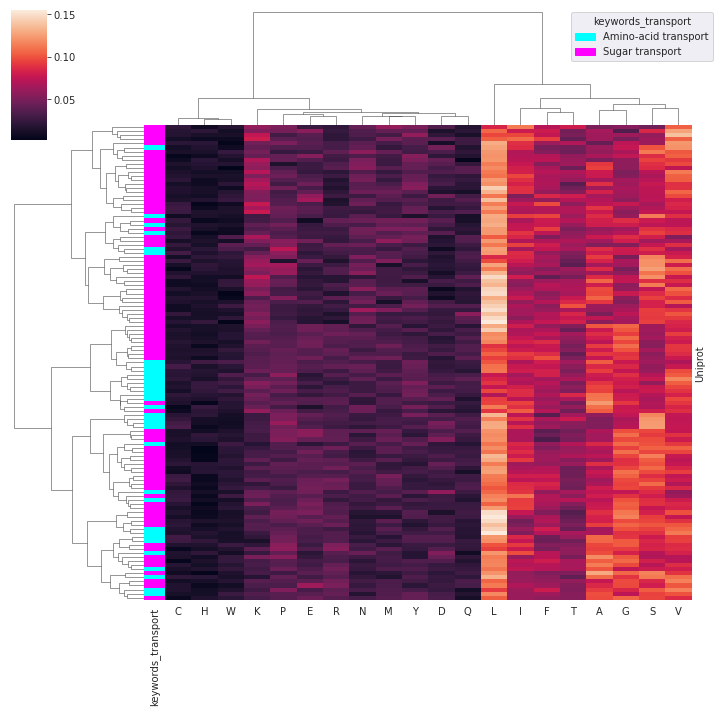

In [19]:
labeled_clustermap(df_aac_clustered, df_clustered.keywords_transport, xlabels="auto")

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7fba1ae21f70>)

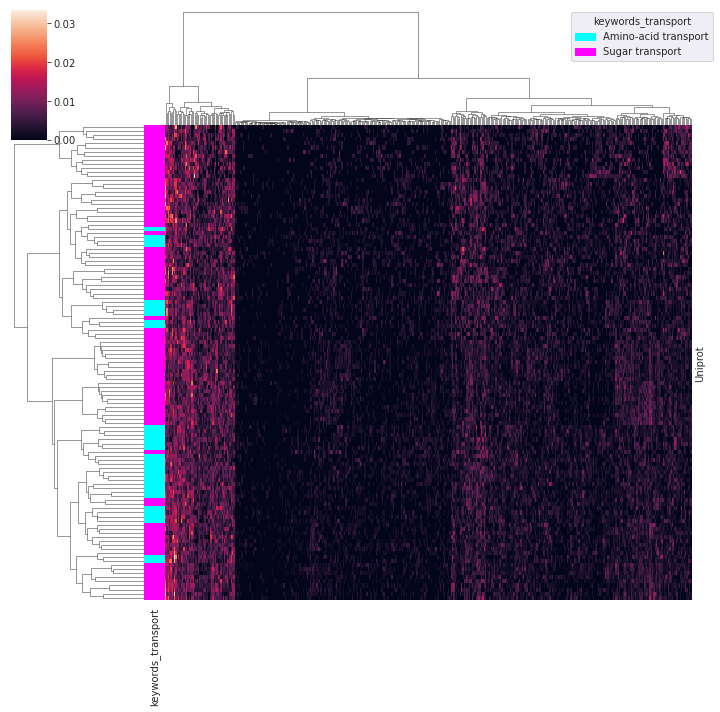

In [20]:
labeled_clustermap(df_paac_clustered, df_clustered.keywords_transport)

Unassigned TCDB classes still seem to mix in with the assigned ones.

({'0.0': 'cyan', '2.A': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7fba19e85880>)

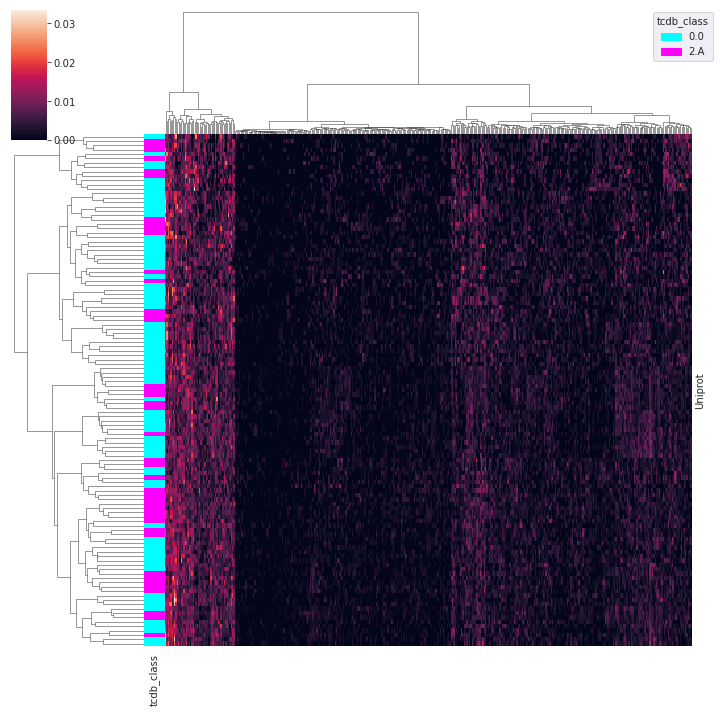

In [21]:
labeled_clustermap(df_paac_clustered, df_clustered.tcdb_class)

There seem to be three clusters: One with only Transport, one that contains the antiporters, and one that contains the symporters. 

({'Antiport;Transport': 'cyan',
  'Symport;Transport': 'magenta',
  'Transport': 'yellow'},
 <seaborn.matrix.ClusterGrid at 0x7fba1e92c640>)

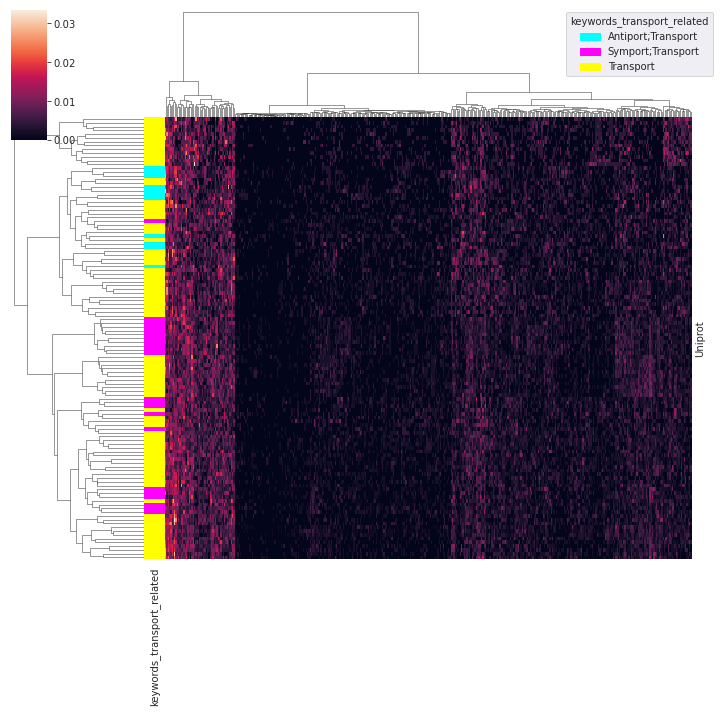

In [22]:
labeled_clustermap(df_paac_clustered, df_clustered.keywords_transport_related)